# Agreement and disagreement between Gaussian posterior distributions

Marco Raveri (<marco.raveri@unige.it>)

This notebook shows an end to end calculation of the agreement and disagreement between two experiments with different methods, in an idealized case and in a realistic case involving two cosmological experiments.

This implements the methods discussed in [Raveri and Hu (2018), arXiv:1806.04649](https://arxiv.org/abs/1806.04649)

In [1]:
# Show plots inline, and load main getdist plot module and samples class
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1
# import libraries:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import IPython
import numpy as np
# tensiometer imports:
from tensiometer import utilities
from tensiometer import gaussian_tension

2024-07-07 11:40:07.138631: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Toy example: 

For a toy example we consider two 2D Gaussian distributions. 
One has correlation between the two parameters while the other does not.
The two Gaussian distributions are displaced a little to result in a mild tension.

In [2]:
# Create the two toy chains and the joint chain:
ndim = 2 # number of dimensions
nsamp = 10000 # number of samples
nchains = 8 # number of chains
# helper function to compute the likelihood:
def helper_gaussian_log_like( samps, mean, invcov ):
    _diff = samps-mean
    return (_diff.dot(invcov)*_diff).sum(axis=1)
# first data set:
mean_1 = np.array([0., 0.])
cov_1 = np.array([[1, -0.9], [-0.9, 1]])
samps_1 = np.random.multivariate_normal(mean_1, cov_1, size=nchains*nsamp)
log_like_1 = helper_gaussian_log_like(samps_1, mean_1, np.linalg.inv(cov_1))
# second data set:
mean_2 = np.array([1., 1.])
cov_2 = np.array([[.09, 0.], [0., .09]])
samps_2 = np.random.multivariate_normal( mean_2, cov_2, size=nchains*nsamp)
log_like_2 = helper_gaussian_log_like(samps_2, mean_2, np.linalg.inv(cov_2))
# joint data set:
cov_12 = np.linalg.inv(np.linalg.inv(cov_1) + np.linalg.inv(cov_2))
mean_12 = np.dot(cov_12, np.dot(np.linalg.inv(cov_1), mean_1) + np.dot(np.linalg.inv(cov_2), mean_2))
samps_12 = np.random.multivariate_normal(mean_12, cov_12, size=nchains*nsamp)
log_like_12 = helper_gaussian_log_like(samps_12, mean_1, np.linalg.inv(cov_1)) \
            + helper_gaussian_log_like(samps_12, mean_2, np.linalg.inv(cov_2))
# initialize the parameter names:
names = ["p%s"%i for i in range(ndim)]
labels = ["p_%s"%i for i in range(ndim)]
# initialize the GetDist chains:
chain_1 = MCSamples(samples=samps_1, loglikes=log_like_1, names=names, labels=labels, label='first')
chain_2 = MCSamples(samples=samps_2, loglikes=log_like_2, names=names, labels=labels, label='second')
chain_12 = MCSamples(samples=samps_12, loglikes=log_like_12, names=names, labels=labels, label='joint')
# separate the chains so that we can have rough convergence estimates:
for chain in [chain_1, chain_2, chain_12]:
    chain.chain_offsets = [i*nsamp for i in range(nchains+1)]

Now we plot the distributions to make sure we are getting a good example:

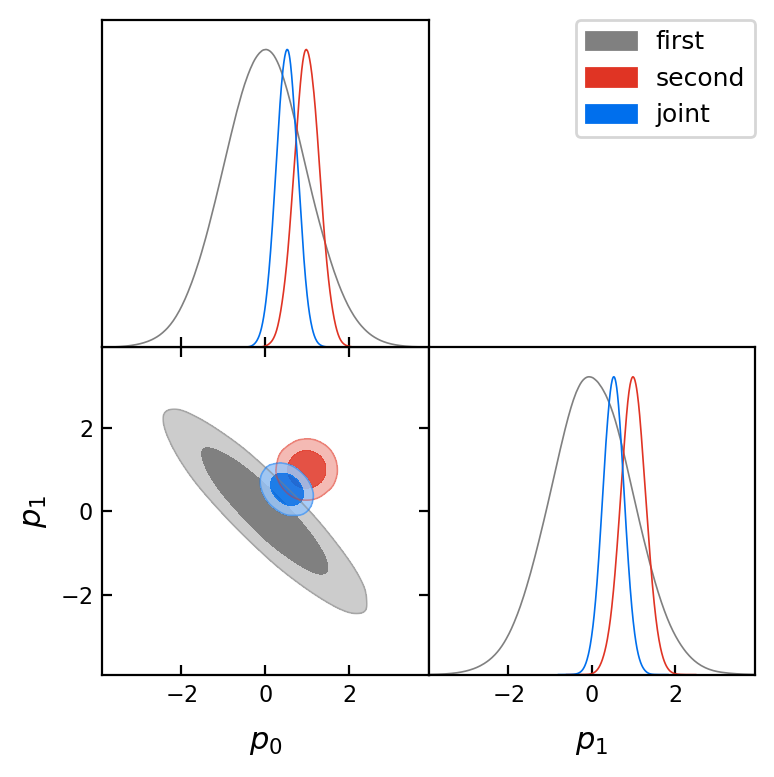

In [3]:
g = plots.get_subplot_plotter()
g.triangle_plot([chain_1, chain_2, chain_12], filled=True)

Clearly if we were to look only at the marginalized posteriors of the two distributions we would probably not guess that the two chains are in tension with each other.
We next proceed to the calculation of the statistical significance of this tension.

We can proceed to compute the statistical significance of the difference in parameters with other estimators, as discussed in [Raveri and Hu (2018), arXiv:1806.04649](https://arxiv.org/abs/1806.04649).
These rely on the Gaussian approximation (though some of them are defined in a way that mitigates possible non-Gaussianities).

### Parameter shifts in standard form

We start by calculating the difference between the means of the two distributions, $\theta_1$ and $\theta_2$.
For optimal weighting of these difference we use the covariance of the $\theta_1-\theta_2$ shift:

\begin{align}
\mathcal{C}_{\rm DM} =
\end{align}

note that this is significantly more complicated than what one might be used to, due to the fact that we are accounting for the presence of a possibly informative prior.
Then the optimal estimator of the significance of the shift is:

\begin{align}
Q_{\rm DM} \equiv (\theta_1-\theta_2)^T \, \mathcal{C}_{\rm DM}^{-1} \, (\theta_1-\theta_2) \sim \chi^2\left[ \mathrm{rank}\, \mathcal{C}_{\rm DM}^{-1}\right]
\end{align}

After calculating the value of $Q_{\rm DM}$ and its degrees of freedom we can calculate the probability to exceed the observed value (which is the statistical significance of the tension).

In [4]:
# calculate Q_DM and its dofs:
Q_DM, Q_DM_dofs = gaussian_tension.Q_DM( chain_1, chain_2 )
# calculate probability to exceed:
Q_DM_P = scipy.stats.chi2.cdf(Q_DM, Q_DM_dofs)
# print everything:
print(f'Q_DM = {Q_DM:.2f}, dofs = {Q_DM_dofs:2}, P = {Q_DM_P:.5f}')

Q_DM = 10.52, dofs =  2, P = 0.99481


Probabilities are usually terrible numbers. The reason beeing that we care about probabilities on a log scale.
We can convert probability values to effective number of sigmas, matching the probability level of the result to those of a Gaussian distribution:

\begin{align}
n_{\sigma} = 
\end{align}

In [5]:
# convert to effective number of sigmas:
Q_DM_nsigma = utilities.from_confidence_to_sigma(Q_DM_P)
# print everything:
print(f'nsigma = {Q_DM_nsigma:.3f}')

nsigma = 2.795


### Parameter shifts in update form

In [6]:
# start calculations:
Q_DM, Q_DM_dofs = gaussian_tension.Q_DM( chain_1, chain_2 )
Q_UDM, Q_UDM_dofs =gaussian_tension.Q_UDM( chain_1, chain_12, lower_cutoff=1. )
Q_DM_P = scipy.stats.chi2.cdf(Q_DM, Q_DM_dofs)
Q_UDM_P = scipy.stats.chi2.cdf(Q_UDM, Q_UDM_dofs)
Q_DM_nsigma = utilities.from_confidence_to_sigma(Q_DM_P)
Q_UDM_nsigma = utilities.from_confidence_to_sigma(Q_UDM_P)
print(f'Q_DM = {Q_DM:.2f}, dofs = {Q_DM_dofs:2}, P = {Q_DM_P:.5f}, nsigma = {Q_DM_nsigma:.3f}')
print(f'Q_UDM = {Q_UDM:.2f}, dofs = {Q_UDM_dofs:2}, P = {Q_UDM_P:.5f}, nsigma = {Q_UDM_nsigma:.3f}')

Q_DM = 10.52, dofs =  2, P = 0.99481, nsigma = 2.795
Q_UDM = 10.67, dofs =  2, P = 0.99519, nsigma = 2.820


That we see match very well, to a fraction of a sigma.

We can now test the behavior of Q_UDM:

In [7]:
# verify that Q_UDM is symmetric in the Gaussian case:
print('Symmetric Q_UDM = %.3f, dofs = %2i' % gaussian_tension.Q_UDM(chain_2, chain_12, lower_cutoff=1.))
# find the optimal cutoff by providing the second chain:
print('Q_UDM optimal cutoff = %.3f' % gaussian_tension.Q_UDM_get_cutoff(chain_1, chain_2, chain_12)[0])
# get the KL spectrum:
print('Q_UDM KL spectrum:', gaussian_tension.Q_UDM_KL_components(chain_1, chain_12)[0])

Symmetric Q_UDM = 10.636, dofs =  2
Q_UDM optimal cutoff = 1.000
Q_UDM KL spectrum: [22.26811745  2.08007895]


As we can see the estimator is symmetric, none of the parameters we are considering is prior limited and the optimal cutoff just leave all directions come through.
We can proceed to compute the chi squared based version of these estimators.
This consists in the statistics of Goodness of fit loss (Q_DMAP) which gives:

In [8]:
Q_DMAP, Q_DMAP_dofs = gaussian_tension.Q_DMAP(chain_1, chain_2, chain_12, feedback=0 )
Q_DMAP_P = scipy.stats.chi2.cdf(Q_DMAP, Q_DMAP_dofs)
Q_DMAP_nsigma = utilities.from_confidence_to_sigma(Q_DMAP_P)
print(f'Q_DMAP = {Q_DMAP:.2f}, dofs = {Q_DMAP_dofs:2}, P = {Q_DMAP_P:.5f}, nsigma = {Q_DMAP_nsigma:.3f}')

Q_DMAP = 10.53, dofs = 2.0, P = 0.99482, nsigma = 2.796


Which is in very good agreement with the previous results, as expected.

## A realistic example, Planck 2018 and DES Y1:

We now turn to a more realistic example that involves a chains from two different (real) experiments.
We use the LCDM parameter chains for the results of Planck 2018 (https://arxiv.org/abs/1807.06209) and the results for the Dark Energy Survey (DES)
first year of data (https://arxiv.org/abs/1708.01530).

Notice that we have removed many parameters from the chains since they were irrelevant to the example.
The chains are already fully polished. Burn in has been removed and the samples have been thinned.

Notice that we have run a prior only chain to ensure that the modeling of the prior is as faithful as possible.
In particular, in standard cosmological analyses, we have priors on derived parameters that would give non-trivial shapes to the parameters that are being sampled (see Appendix F in https://arxiv.org/abs/1806.04649)

In [9]:
# load the samples (remove no burn in since the example chains have already been cleaned):
chains_dir = './../../test_chains/'
# the Planck 2018 TTTEEE chain:
chain_1 = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'Planck18TTTEEE', no_cache=True)
# the DES Y1 3x2 chain:
chain_2 = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True)
# the joint chain:
chain_12 = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'Planck18TTTEEE_DES', no_cache=True)
# the prior chain:
prior_chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'prior', no_cache=True)

We first plot the chains to get some intuition of what is happening.
We show only the parameters that have been run and that the two chains share.
These are the only parameters that can contribute to a tension between the two experiments.

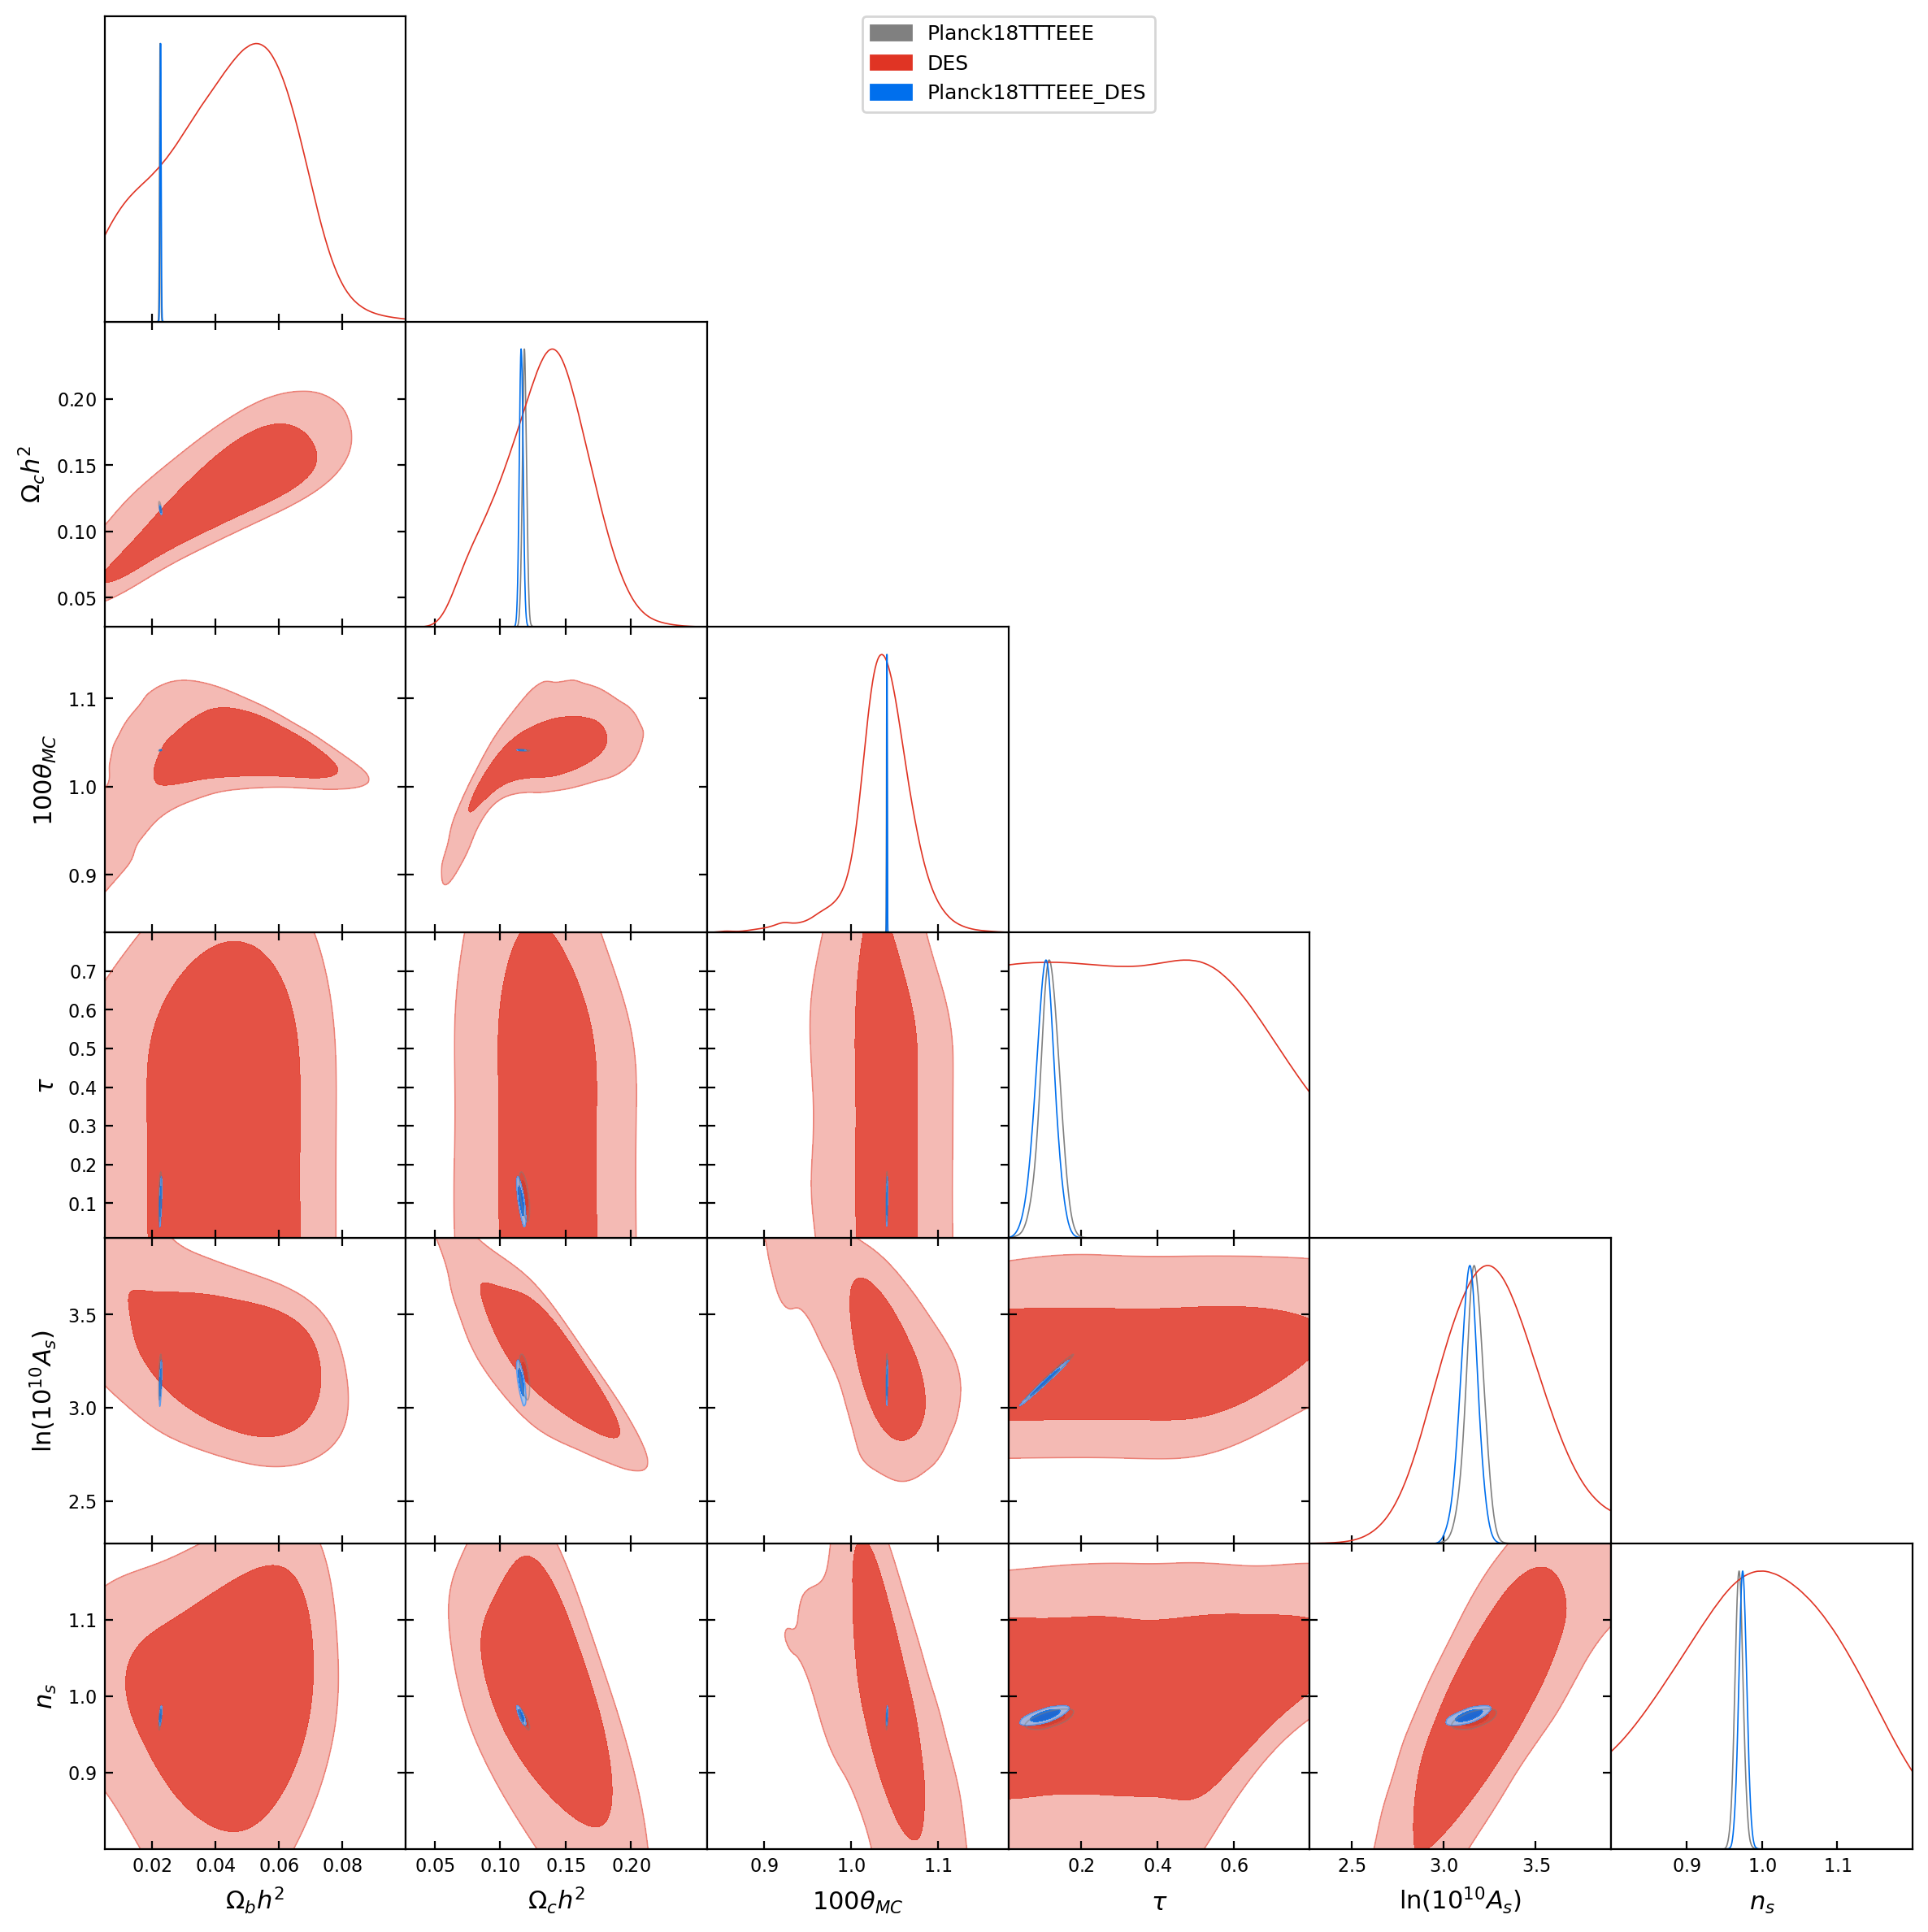

In [10]:
shared_param_names = [name for name in chain_1.getParamNames().getRunningNames() 
                      if name in chain_2.getParamNames().getRunningNames()]
g = plots.get_subplot_plotter()
g.triangle_plot([chain_1, chain_2, chain_12], params=shared_param_names, filled=True)

Given this plot it is not obvious at all whether the two experiments agree or not. 

Moreover, while Planck might still look Gaussian, DES looks like it has a very non-Gaussian posterior.

If we try another parameter combination:

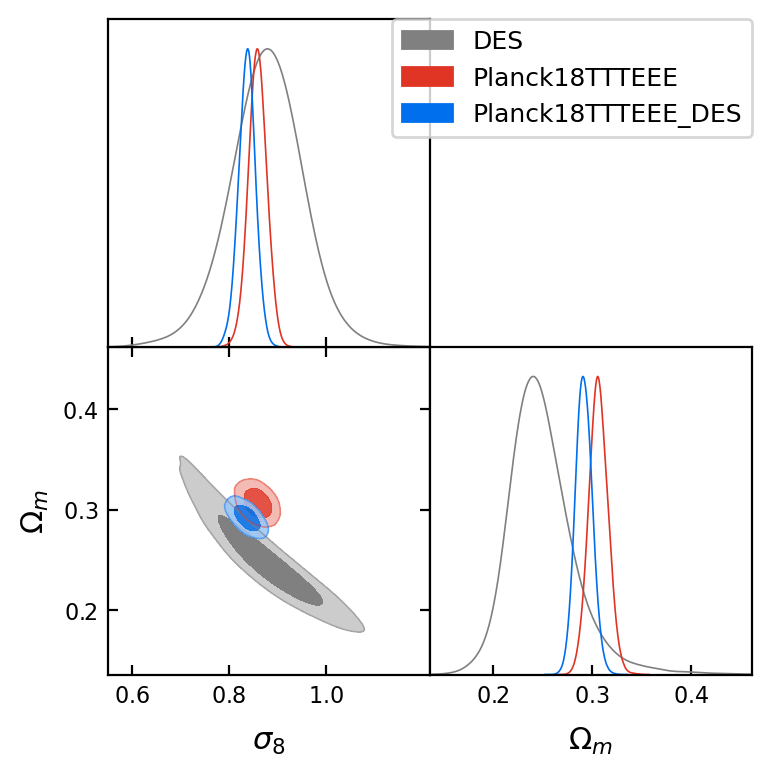

In [11]:
g = plots.get_subplot_plotter()
g.triangle_plot([chain_2, chain_1, chain_12], params=['sigma8','omegam'], filled=True)

The situation looks very different. We have selected the two parameters that the weakest data set (DES) best constrains and in this plane the two data sets do not look in agreement.
They look fairly similar to our toy example! Coincidence?

The posteriors also look more Gaussian since we are selecting at the best constrained directions. 
This is a very common problem. When looking at some parameter that is partially informed by the prior the posterior might look non-Gaussian because of prior volume projections.

We can compute the number of parameters that our data sets are truly constraining over the prior.

In [12]:
Neff_1 = gaussian_tension.get_Neff(chain_1, param_names=shared_param_names, prior_chain=prior_chain)
Neff_2 = gaussian_tension.get_Neff(chain_2, param_names=shared_param_names, prior_chain=prior_chain)
Neff_12 = gaussian_tension.get_Neff(chain_12, param_names=shared_param_names, prior_chain=prior_chain)
print(f'Neff(Planck) = {Neff_1:.2f}, Neff(DES) = {Neff_2:.2f}, Neff(joint) = {Neff_12:.2f}')

Neff(Planck) = 5.98, Neff(DES) = 3.31, Neff(joint) = 5.98


It is no surprise that Planck is constraining all six cosmological parameters while DES is constraining three.
In addition to the two parameters, that we have shown in the plot above, DES is constraining the angular scale of the BAO peak, as we can see by directly feeding the parameters to use in the calculation:

In [13]:
Neff_2 = gaussian_tension.get_Neff(chain_2, param_names=['sigma8','omegam','theta_BAO_DES'], prior_chain=prior_chain)
print(f'Neff(DES) = {Neff_2:.2f}')
# the extra 0.5 parameter is a very weak constraint on n_s.

Neff(DES) = 2.83


Since these are real data we can check the Goodness of their fit at maximum posterior.

In [14]:
## in our case the DES data set has 457 data points and the Planck one has 2289
# if we were to normalize the likelihood we need to subtract the normalization factor to get the chi2.
Q_MAP_1 = gaussian_tension.Q_MAP(chain_1, num_data=2289, prior_chain=prior_chain)
Q_MAP_2 = gaussian_tension.Q_MAP(chain_2, num_data=457, prior_chain=prior_chain)
Q_MAP_12 = gaussian_tension.Q_MAP(chain_12, num_data=2289+457, prior_chain=prior_chain)
# get the probability:
Q_MAP_1_P = scipy.stats.chi2.cdf(*Q_MAP_1)
Q_MAP_2_P = scipy.stats.chi2.cdf(*Q_MAP_2)
Q_MAP_12_P = scipy.stats.chi2.cdf(*Q_MAP_12)
# print results:
print(f'Goodness of fit for Planck TTTEEE: Q_MAP = {Q_MAP_1[0]:.3f} with dofs {Q_MAP_1[1]:.3f}')
print(f'Q_MAP probability = {Q_MAP_1_P:.5f}, n_sigma = {utilities.from_confidence_to_sigma(Q_MAP_1_P):.3f}\n')
print(f'Goodness of fit for DES: Q_MAP = {Q_MAP_2[0]:.3f} with dofs {Q_MAP_2[1]:.3f}')
print(f'Q_MAP probability = {Q_MAP_2_P:.5f}, n_sigma = {utilities.from_confidence_to_sigma(Q_MAP_2_P):.3f}\n')
print(f'Goodness of fit for joint: Q_MAP = {Q_MAP_12[0]:.3f} with dofs {Q_MAP_12[1]:.3f}')
print(f'Q_MAP probability = {Q_MAP_12_P:.5f}, n_sigma = {utilities.from_confidence_to_sigma(Q_MAP_12_P):.3f}')

Goodness of fit for Planck TTTEEE: Q_MAP = 2337.482 with dofs 2283.021
Q_MAP probability = 0.79088, n_sigma = 1.256

Goodness of fit for DES: Q_MAP = 499.154 with dofs 453.685
Q_MAP probability = 0.93106, n_sigma = 1.819

Goodness of fit for joint: Q_MAP = 2850.685 with dofs 2740.021
Q_MAP probability = 0.93113, n_sigma = 1.819


This tells us that the maximum posterior is a fairly good fit to the data.

Then we check the reliability of the Gaussian approximation:

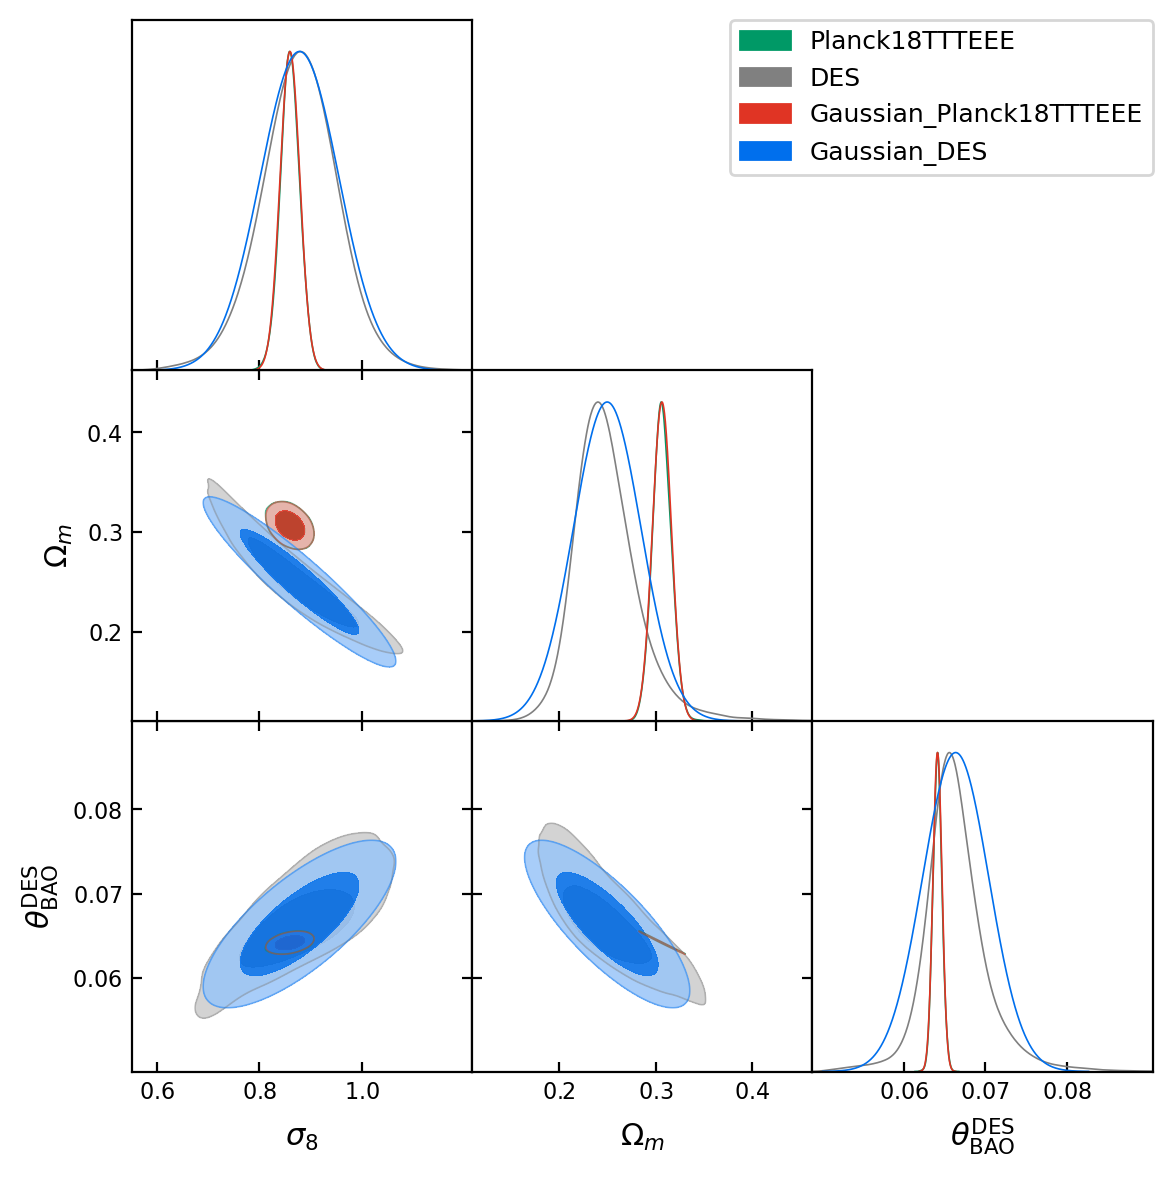

In [15]:
# get the Gaussian approximation:
gaussian_1 = gaussian_tension.gaussian_approximation(chain_1)
gaussian_2 = gaussian_tension.gaussian_approximation(chain_2)
# plot for comparison:
g = plots.get_subplot_plotter()
g.triangle_plot([chain_1, chain_2, gaussian_1, gaussian_2], params=['sigma8','omegam','theta_BAO_DES'], filled=True)

### Gaussian estimators:

We start by considering parameter shifts in standard form over the three constrained parameters and over the full parameter space.

In [16]:
# start with Q_DM:
Q_DM = gaussian_tension.Q_DM(chain_1, chain_2, prior_chain=prior_chain, param_names=['sigma8', 'omegam','theta_BAO_DES'])
Q_DM_full = gaussian_tension.Q_DM(chain_1, chain_2, prior_chain=prior_chain, param_names=shared_param_names)
# compute probability:
Q_DM_P = scipy.stats.chi2.cdf(*Q_DM)
Q_DM_full_P = scipy.stats.chi2.cdf(*Q_DM_full)
# print results:
print(f'Using only sigma8 and Omegam: Q_DM = {Q_DM[0]:.3f} with dofs {Q_DM[1]:.3f}')
print(f'Q_DM probability = {Q_DM_P:.5f}, n_sigma = {utilities.from_confidence_to_sigma(Q_DM_P):.3f}')
print(f'Using all parameters: Q_DM = {Q_DM_full[0]:.3f} with dofs {Q_DM_full[1]:.3f}')
print(f'Q_DM probability = {Q_DM_full_P:.5f}, n_sigma = {utilities.from_confidence_to_sigma(Q_DM_full_P):.3f}')

Using only sigma8 and Omegam: Q_DM = 9.953 with dofs 3.000
Q_DM probability = 0.98103, n_sigma = 2.346
Using all parameters: Q_DM = 4.219 with dofs 5.000
Q_DM probability = 0.48162, n_sigma = 0.646


As we can see the result is significantly different and different from what we would expect from the previous results. This happens because, in standard form, Gaussian parameter shifts are not mitigated against non-Gaussianities. Moreover, in the full parameter space the effect of the prior is hard to be removed. As we can see the full parameter space Q_DM is reporting five degrees of freedom which is wrong since we know that that cannot exceed the number of parameters measured by DES (3).

Parameter shifts in update form, that we consider next, offer some mitigation against non-Gaussianities while being more effective at detecting data constrained parameter space directions:

In [17]:
# now Q_UDM:
Q_UDM = gaussian_tension.Q_UDM(chain_1, chain_12, param_names=['sigma8', 'omegam','theta_BAO_DES'])
Q_UDM_full = gaussian_tension.Q_UDM(chain_1, chain_12, param_names=shared_param_names)
# compute probability:
Q_UDM_P = scipy.stats.chi2.cdf(*Q_UDM)
Q_UDM_full_P = scipy.stats.chi2.cdf(*Q_UDM_full)
# print results:
print(f'Using only sigma8 and Omegam: Q_UDM = {Q_UDM[0]:.3f} with dofs {Q_UDM[1]:.3f}')
print(f'Q_UDM probability = {Q_UDM_P:.5f}, n_sigma = {utilities.from_confidence_to_sigma(Q_UDM_P):.3f}')
print(f'Using all parameters: Q_UDM = {Q_UDM_full[0]:.3f} with dofs {Q_UDM_full[1]:.3f}')
print(f'Q_UDM probability = {Q_UDM_full_P:.5f}, n_sigma = {utilities.from_confidence_to_sigma(Q_UDM_full_P):.3f}')

Using only sigma8 and Omegam: Q_UDM = 11.900 with dofs 2.000
Q_UDM probability = 0.99739, n_sigma = 3.011
Using all parameters: Q_UDM = 12.127 with dofs 2.000
Q_UDM probability = 0.99767, n_sigma = 3.045


As we can see these two estimates agree very well with each other since the separation of data constrained directions is more stable. The results also agree very well with the exact result showing that non-Gaussianities are effectively mitigated by considering Planck as the base for the update.

In this case it is important to select as the base for the update parameter shifts the most constraining (and most Gaussian) data set. If we were to use DES (which is non-Gaussian!) as a base for the update we would get a different result:

In [18]:
# now Q_UDM:
Q_UDM = gaussian_tension.Q_UDM(chain_2, chain_12, param_names=['sigma8', 'omegam','theta_BAO_DES'])
Q_UDM_full = gaussian_tension.Q_UDM(chain_2, chain_12, param_names=shared_param_names)
# compute probability:
Q_UDM_P = scipy.stats.chi2.cdf(*Q_UDM)
Q_UDM_full_P = scipy.stats.chi2.cdf(*Q_UDM_full)
# print results:
print(f'Using only sigma8 and Omegam: Q_UDM = {Q_UDM[0]:.3f} with dofs {Q_UDM[1]:.3f}')
print(f'Q_UDM probability = {Q_UDM_P:.5f}, n_sigma = {utilities.from_confidence_to_sigma(Q_UDM_P):.3f}')
print(f'Using all parameters: Q_UDM = {Q_UDM_full[0]:.3f} with dofs {Q_UDM_full[1]:.3f}')
print(f'Q_UDM probability = {Q_UDM_full_P:.5f}, n_sigma = {utilities.from_confidence_to_sigma(Q_UDM_full_P):.3f}')

Using only sigma8 and Omegam: Q_UDM = 6.827 with dofs 2.000
Q_UDM probability = 0.96708, n_sigma = 2.133
Using all parameters: Q_UDM = 3.594 with dofs 2.000
Q_UDM probability = 0.83421, n_sigma = 1.386


which is wrong since it is heavily contaminated by non-Gaussianities.

Finally we compute Goodness of fit loss:

In [19]:
# at last Q_DMAP:
Q_DMAP = gaussian_tension.Q_DMAP(chain_1, chain_2, chain_12, prior_chain=prior_chain, param_names=shared_param_names)
Q_DMAP_P = scipy.stats.chi2.cdf(Q_DMAP[0],Q_DMAP[1])
print(f'Using all parameters: Q_DMAP = {Q_DMAP[0]:.3f} with dofs {Q_DMAP[1]:.3f}')
print(f'Q_DMAP probability = {Q_DMAP_P:.5f}, n_sigma = {utilities.from_confidence_to_sigma(Q_DMAP_P):.3f}')

Using all parameters: Q_DMAP = 14.049 with dofs 3.315
Q_DMAP probability = 0.99612, n_sigma = 2.888


that we see agrees with the correct result, to a fraction of a sigma.

Possibly some of the discrepancy here is that the estimator is not fully mitigating non-Gaussianities.

Overall we can conclude that a set of reliable estimators agree on a tension between our two input data sets that ranges between 2.8 and 3.2 sigma.